## 1. Preprocessing

In [1]:
%matplotlib inline
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot.metrics as skplt
import math
import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import datasets

import gensim
import string
import pickle
import re
import nltk
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet


from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import uniform

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from collections import Counter
from sklearn.calibration import CalibratedClassifierCV

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

1.1 Load the data

In [3]:
con = sqlite3.connect('database.sqlite')

messages = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)

print(messages.shape)
messages

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


1.2 Remove duplicates and null value

In [4]:
messages["Time"] = messages["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))
sortedData = messages.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)
# drop row that include null value in text column and score column
messages = final[['Time','Text','Score']].dropna()
final.shape

(364173, 10)

1.3 Distribution of original data

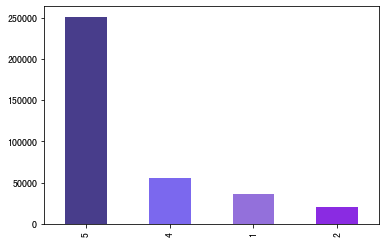

In [5]:
color_bar = ['darkslateblue','mediumslateblue','mediumpurple','blueviolet','darkorchid','darkviolet','mediumorchid',
             'm','fuchsia','magenta','orchid','deeppink','hotpink','pink','lightpink']
ax=messages.Score.value_counts().plot(kind='bar',color=color_bar)
fig = ax.get_figure()
fig.savefig("score_origin.png");

1.4 Transform origianl score to negative and positive

As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

,Time,Text,Score
138706,1999-10-08 08:00:00,this witty little book makes my son laugh at l...,positive
138688,2007-11-11 08:00:00,"I grew up reading these Sendak books, and watc...",positive
138689,2007-10-04 08:00:00,This is a fun way for children to learn their ...,positive
138690,2004-02-06 08:00:00,This is a great little book to read aloud- it ...,positive
138691,2002-04-10 08:00:00,This is a book of poetry about the months of t...,positive


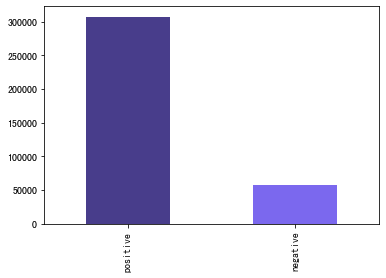

In [6]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

score = messages['Score']
messages['Score'] = score.map(partition)
text = messages['Text']

# split and see the rating distribution
ax=messages['Score'].value_counts().plot(kind='bar',color=color_bar)
fig = ax.get_figure()
fig.savefig("score_pos_neg.png")
messages.head()

1.5 Down sampling and split the data

Down sampling and form a balanced dataset

,Time,Text,Score
209484,2011-11-19 08:00:00,"Just as described, unbeatable price, Great tas...",positive
140711,2011-08-23 08:00:00,When I adopted my two female kitties two years...,positive
227135,2012-03-20 08:00:00,We keep our voices clear with mints and other ...,positive
225124,2012-03-26 08:00:00,This protein is great quality for the value(ar...,positive
15481,2009-05-21 08:00:00,These drinks are pretty good. Nice to have so...,positive
...,...,...,...
240366,2012-01-20 08:00:00,I love Amazon but for this particular product ...,negative
350289,2012-06-23 08:00:00,I am recently pregnant and have just switched ...,negative
115382,2011-05-19 08:00:00,I posted Lindt a letter at their site and then...,negative
175291,2012-04-08 08:00:00,"Although my cats loved the taste of this food,...",negative


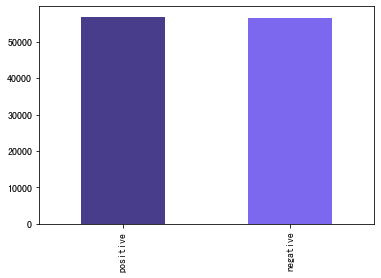

In [14]:
score = messages['Score']
text = messages['Text']
finalp = messages[messages.Score == 'positive']
finalp = finalp.sample(frac=0.185,random_state=1)

finaln = messages[messages.Score == 'negative']
finaln = finaln.sample(frac=0.99,random_state=1)


final = pd.concat([finalp,finaln],axis=0)
final['Score'].value_counts().plot(kind='bar',color=color_bar)
final

The data will be split into an training set and a test set with a test set ratio of 0.2

In [22]:
score = final['Score']
text = final['Text']

x_train, x_test, y_train, y_test = train_test_split(text, score, test_size=0.2, random_state=50)

## 2. Data Cleaning

To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :

- Lowering
- Stop words removal
- Pruning (numbers and punctuation)
- POS(part of speech)
- Lemmatization

In [15]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ivy_Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ivy_Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ivy_Chen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
# 获取单词的词性
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [20]:
def tokenize(text,wnl):
    tokens = nltk.word_tokenize(text)
    tagged_sent = pos_tag(tokens)     # 获取单词词性
#     tokens = [word for word in tokens if word not in stopwords.words('english')]
    lems = lem_tokens(tagged_sent, wnl)
    return ' '.join(lems)

In [18]:
def lem_tokens(tagged_sent, wnl):
    lemmas_sent = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        lemmas_sent.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) # 词形还原
    return lemmas_sent

In [19]:
def lem_lower_pruning(x_train,x_test,wnl):
    intab = string.punctuation
    outtab = "                                "
    trantab = str.maketrans(intab, outtab)
    
    total=len(x_train)+len(x_test)
    cnt=0

    #--- Training set
    corpus = []
    for text in x_train:
        text = text.lower()
        text = text.translate(trantab)
        text=tokenize(text,wnl)
        corpus.append(text)
        cnt += 1
        if cnt%(int(total/20))==0:
            print ("%d%% finished" % (5*cnt/(int(total/20))))

    #--- Test set
    test_set = []
    for text in x_test:
        text = text.lower()
        text = text.translate(trantab)
        text=tokenize(text,wnl)
        test_set.append(text)
        cnt += 1
        if cnt%(int(total/20))==0:
            print ("%d%% finished" % (5*cnt/(int(total/20))))
    
    df = pd.DataFrame({'Before': x_train, 'After': corpus})
    print(df.head(10))

    prediction = dict()
    return corpus, test_set

In [74]:
sentence = 'football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.'
tokens = word_tokenize(sentence)  # 分词
tagged_sent = pos_tag(tokens)     # 获取单词词性
tagged_sent

[('football', 'NN'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('family', 'NN'),
 ('of', 'IN'),
 ('team', 'NN'),
 ('sports', 'NNS'),
 ('that', 'WDT'),
 ('involve', 'VBP'),
 (',', ','),
 ('to', 'TO'),
 ('varying', 'VBG'),
 ('degrees', 'NNS'),
 (',', ','),
 ('kicking', 'VBG'),
 ('a', 'DT'),
 ('ball', 'NN'),
 ('to', 'TO'),
 ('score', 'VB'),
 ('a', 'DT'),
 ('goal', 'NN'),
 ('.', '.')]

In [23]:
wnl = WordNetLemmatizer()
x_train, x_test = lem_lower_pruning(x_train,x_test,wnl)

5% finished
10% finished
15% finished
20% finished
25% finished
30% finished
35% finished
40% finished
45% finished
50% finished
55% finished
60% finished
65% finished
70% finished
75% finished
80% finished
85% finished
90% finished
95% finished
100% finished
                                                   Before  \
177116  This product tastes okay; not great. It's defi...   
351105  I think these things are disgusting.  I have c...   
421436  These were not my first purchase of vanilla be...   
325735  We tried to switch to a less expensive brand, ...   
50097   This coconut oil is the best - nice taste, nic...   
106714  You can purchase this product at the supermark...   
517177  These candies are wonderful especially when yo...   
73605   I think Baja Bob's is terrific!  I took anothe...   
233668  I was sent one bag of Texas Hold 'Ems instead ...   
110652  I ordered 3 sticks and was pleasantly surprise...   

                                                    After  
177116  

## 3. Feature Extraction

### 3.1 Uni-Gram

In [24]:
unigram = CountVectorizer()
x_uni = unigram.fit_transform(x_train)
x_uni_test = unigram.transform(x_test)

### 3.2 TF-IDF

In [25]:
tf_idf_vect = TfidfVectorizer()
x_tfidf = tf_idf_vect.fit_transform(x_train)
x_tfidf_test = tf_idf_vect.transform(x_test)

## 4. Fitting the models

### 4.1 Result Plot and Analysis

In [26]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

In [27]:
def result_plot(prediction):
    cmp = 0
    colors = ['b', 'g', 'y', 'm', 'k']
    for model, predicted in prediction.items():
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
        cmp += 1

    plt.title('Classifiers comparaison with ROC')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### 4.2 Multinomial Naïve Bayes model

In [28]:
prediction_mnb = dict()

uni-Gram, bi-Gram, tfidf, uni-Gram and tfidf

In [29]:
mnb_uni_model = MultinomialNB().fit(x_uni, y_train)
prediction_mnb['Multinomial-NB-uni'] = mnb_uni_model.predict(x_uni_test)

In [30]:
mnb_tfidf_model = MultinomialNB().fit(x_tfidf, y_train)
prediction_mnb['Multinomial-NB-tfidf'] = mnb_tfidf_model.predict(x_tfidf_test)

Result Analysis

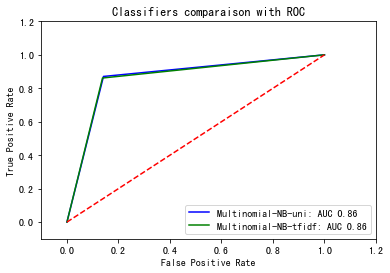

In [31]:
result_plot(prediction_mnb)

### 4.3 Bernoulli Naïve Bayes model

In [32]:
prediction_bnb = dict()

uni-Gram, bi-Gram, tfidf, uni-Gram and tfidf

In [33]:
bnb_uni_model = BernoulliNB().fit(x_uni, y_train)
prediction_bnb['Bernoulli-NB-uni'] = bnb_uni_model.predict(x_uni_test)

In [34]:
bnb_tfidf_model = BernoulliNB().fit(x_tfidf, y_train)
prediction_bnb['Bernoulli-NB-tfidf'] = bnb_tfidf_model.predict(x_tfidf_test)

Result Analysis

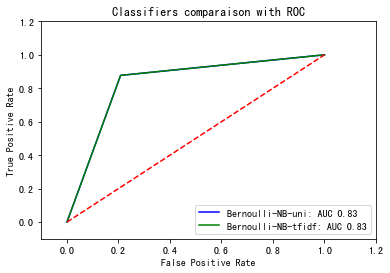

In [35]:
result_plot(prediction_bnb)

### 4.4 Logistic regression model

In [36]:
prediction_lr = dict()

uni-Gram, bi-Gram, tfidf, uni-Gram and tfidf

In [37]:
lr_uni_model = LogisticRegression(C=1e5,n_jobs=-1)
lr_uni_model.fit(x_uni, y_train)
prediction_lr['Logistic_lr_uni'] = lr_uni_model.predict(x_uni_test)

In [38]:
lr_tfidf_model = LogisticRegression(C=1e5,n_jobs=-1).fit(x_tfidf, y_train)
prediction_lr['Logistic_lr_tfidf'] = lr_tfidf_model.predict(x_tfidf_test)

Result Analysis

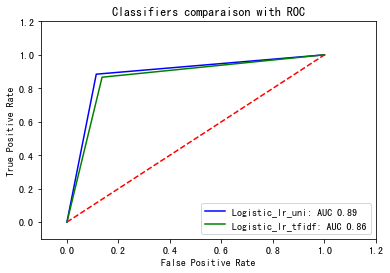

In [39]:
result_plot(prediction_lr)

### 4.5 SVM model

In [40]:
prediction_svm = dict()

In [41]:
svm_uni_model = SGDClassifier(n_jobs = -1).fit(x_uni, y_train)
prediction_svm['svm_uni'] = svm_uni_model.predict(x_uni_test)

In [42]:
svm_tfidf_model = SGDClassifier(n_jobs = -1).fit(x_tfidf, y_train)
prediction_svm['svm_tfidf'] = svm_tfidf_model.predict(x_tfidf_test)

Result Analysis

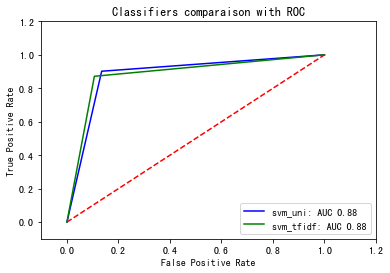

In [43]:
result_plot(prediction_svm)

## 5. Adjust parameters

We choose the best two models that perform the best: Logistic Regression and SVM model. We need to adjust the parameters to form a better result.

### 5.1 Logistic Regression

Finding the optimal C and iteration using gridsearch

In [65]:
def find_optimal_params(x_train,y_train,C_values,max_iter):
   
    LR = LogisticRegression(penalty='l2',n_jobs=-1)
    hyperParam = [{'C':C_values,'max_iter': max_iter}]
    gsv = GridSearchCV(LR,hyperParam,cv=5,verbose=1,scoring='roc_auc',n_jobs=-1)
    gsv.fit(x_train,y_train)
    print("Best HyperParameter: ",gsv.best_params_)
    print(gsv.best_score_)
    scores = gsv.cv_results_['mean_test_score'].reshape(len(max_iter),len(C_values))

    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('max_iter')
    plt.ylabel('C_values')
    plt.colorbar()
    plt.xticks(np.arange(len(max_iter)), max_iter)
    plt.yticks(np.arange(len(C_values)), C_values)
    plt.title('Grid Search f1 Score')
    plt.show()
    
    return gsv.best_params_

5.1.1 Uni-Gram

Fitting 5 folds for each of 169 candidates, totalling 845 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed:  7.6min finished


Best HyperParameter:  {'C': 0.1, 'max_iter': 250}
0.9478421102883686


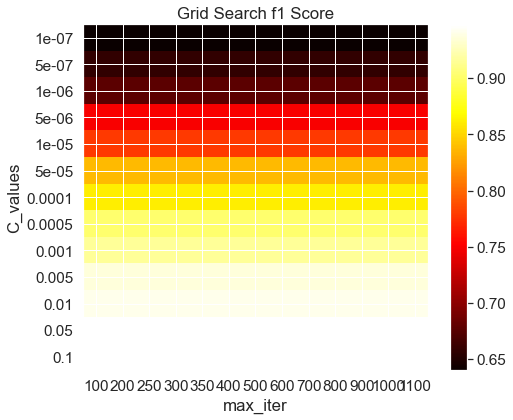

In [66]:
C_value = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
max_iter = [100,200,250,300,350,400,500,600,700,800,900,1000,1100]
optimal_params_lr = find_optimal_params(x_uni,y_train,C_value,max_iter)

Accuracy on test set: 88.730%
Precision on test set: 0.887
Recall on test set: 0.887
F1-Score on test set: 0.887


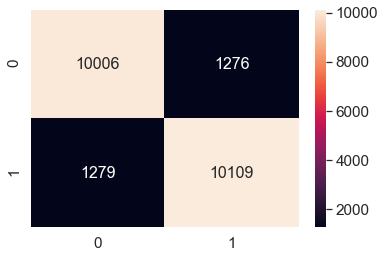

In [67]:
LR= LogisticRegression(penalty='l2',C=optimal_params_lr['C'],max_iter=optimal_params_lr['max_iter'])
LR.fit(x_uni,y_train)
y_pred_lr_uni =LR.predict(x_uni_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_lr_uni)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_lr_uni,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_lr_uni,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_lr_uni,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_lr_uni), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [68]:
print(classification_report(y_test ,y_pred_lr_uni))
print("Accuracy for Logistic Regression model with uni-Gram is ",round(accuracy_score(y_test ,y_pred_lr_uni),3))

              precision    recall  f1-score   support

    negative       0.89      0.89      0.89     11282
    positive       0.89      0.89      0.89     11388

    accuracy                           0.89     22670
   macro avg       0.89      0.89      0.89     22670
weighted avg       0.89      0.89      0.89     22670

Accuracy for Logistic Regression model with uni-Gram is  0.887


5.1.2 TFIDF

Fitting 5 folds for each of 169 candidates, totalling 845 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed:  2.3min finished


Best HyperParameter:  {'C': 1, 'max_iter': 200}
0.9554488225912803


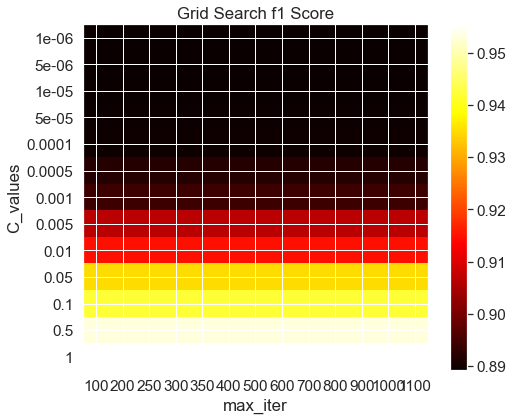

In [84]:
C_value = [0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]
max_iter = [100,200,250,300,350,400,500,600,700,800,900,1000,1100]
optimal_params_lr_tfidf = find_optimal_params(x_tfidf,y_train,C_value,max_iter)

Accuracy on test set: 88.769%
Precision on test set: 0.888
Recall on test set: 0.888
F1-Score on test set: 0.888


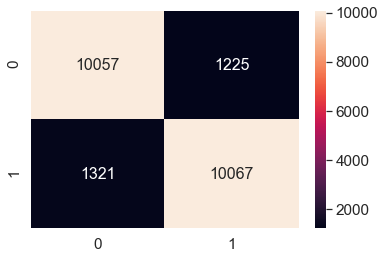

In [85]:
LR= LogisticRegression(penalty='l2',C=optimal_params_lr_tfidf['C'],max_iter=optimal_params_lr_tfidf['max_iter'])
LR.fit(x_tfidf,y_train)
y_pred_lr_tfidf =LR.predict(x_tfidf_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_lr_tfidf)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_lr_tfidf,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_lr_tfidf,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_lr_tfidf,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_lr_tfidf), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [98]:
print(classification_report(y_test ,y_pred_lr_tfidf))
print("Accuracy for Logistic Regression model with tfidf is ",round(accuracy_score(y_test ,y_pred_lr_tfidf),3))

              precision    recall  f1-score   support

    negative       0.88      0.89      0.89     11282
    positive       0.89      0.88      0.89     11388

    accuracy                           0.89     22670
   macro avg       0.89      0.89      0.89     22670
weighted avg       0.89      0.89      0.89     22670

Accuracy for Logistic Regression model with tfidf is  0.888


### 5.2 SVM

Finding the optimal alpha and iteration using gridsearch

In [87]:
def find_optimal_params_svm(x_train,y_train,alpha_values,max_iter):
   
    SGD = SGDClassifier(loss = 'hinge', class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1)
    hyperParam = [{'alpha':alpha_values,'max_iter': max_iter}]
    gsv = GridSearchCV(SGD,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
    gsv.fit(x_train,y_train)
    print("Best HyperParameter: ",gsv.best_params_)
    print(gsv.best_score_)
    scores = gsv.cv_results_['mean_test_score'].reshape(len(max_iter),len(alpha_values))

    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('max_iter')
    plt.ylabel('alpha_values')
    plt.colorbar()
    plt.xticks(np.arange(len(max_iter)), max_iter)
    plt.yticks(np.arange(len(alpha_values)), alpha_values)
    plt.title('Grid Search f1 Score')
    plt.show()
    
    return gsv.best_params_

5.2.1 Uni-Gram

Fitting 5 folds for each of 169 candidates, totalling 845 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed:  5.5min finished


Best HyperParameter:  {'alpha': 0.0005, 'max_iter': 1000}
0.8872407375744412


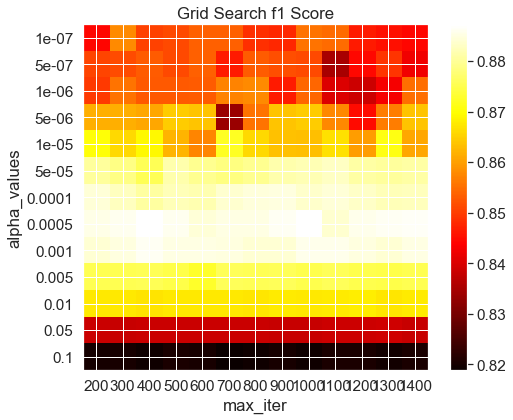

In [88]:
alpha_value = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
max_iter = [200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]
optimal_params_svm = find_optimal_params_svm(x_uni,y_train,alpha_value,max_iter)

Accuracy on test set: 88.769%
Precision on test set: 0.888
Recall on test set: 0.888
F1-Score on test set: 0.888


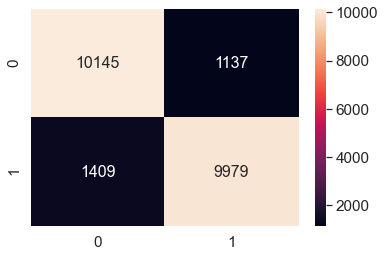

In [94]:
SGD = SGDClassifier(loss = 'hinge',alpha=optimal_params_svm['alpha'],max_iter=optimal_params_svm['max_iter'],class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1)
SGD.fit(x_uni,y_train)
y_pred_svm_uni =SGD.predict(x_uni_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_svm_uni)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_svm_uni,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_svm_uni,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_svm_uni,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_svm_uni), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [95]:
print(classification_report(y_test ,y_pred_svm_uni))
print("Accuracy for SVM model with uni-Gram is ",round(accuracy_score(y_test ,y_pred_svm_uni),3))

              precision    recall  f1-score   support

    negative       0.88      0.90      0.89     11282
    positive       0.90      0.88      0.89     11388

    accuracy                           0.89     22670
   macro avg       0.89      0.89      0.89     22670
weighted avg       0.89      0.89      0.89     22670

Accuracy for SVM model with uni-Gram is  0.888


5.2.2 TFIDF

Fitting 5 folds for each of 169 candidates, totalling 845 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 845 out of 845 | elapsed:  1.9min finished


Best HyperParameter:  {'alpha': 1e-05, 'max_iter': 600}
0.8903073056657658


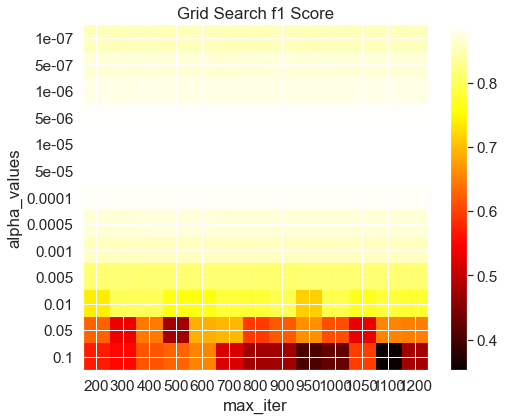

In [93]:
alpha_value = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
max_iter = [200,300,400,500,600,700,800,900,950,1000,1050,1100,1200]
optimal_params_svm_tfidf = find_optimal_params_svm(x_tfidf,y_train,alpha_value,max_iter)

Accuracy on test set: 88.933%
Precision on test set: 0.889
Recall on test set: 0.889
F1-Score on test set: 0.889


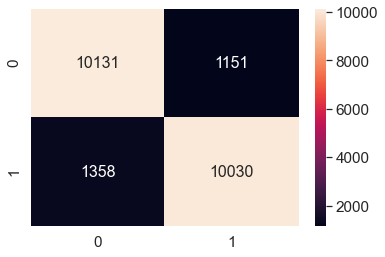

In [96]:
SGD = SGDClassifier(loss = 'hinge',alpha=optimal_params_svm_tfidf['alpha'],max_iter=optimal_params_svm_tfidf['max_iter'],class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1)
SGD.fit(x_tfidf,y_train)
y_pred_svm_tfidf =SGD.predict(x_tfidf_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred_svm_tfidf)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred_svm_tfidf,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred_svm_tfidf,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred_svm_tfidf,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_svm_tfidf), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [97]:
print(classification_report(y_test ,y_pred_svm_tfidf))
print("Accuracy for SVM model with tfidf is ",round(accuracy_score(y_test ,y_pred_svm_tfidf),3))

              precision    recall  f1-score   support

    negative       0.88      0.90      0.89     11282
    positive       0.90      0.88      0.89     11388

    accuracy                           0.89     22670
   macro avg       0.89      0.89      0.89     22670
weighted avg       0.89      0.89      0.89     22670

Accuracy for SVM model with tfidf is  0.889
